In [1]:
from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv, PenalizeDeathEnv
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)

#env = PenalizeDeathEnv(env, COMPLEX_MOVEMENT)

In [2]:
# env = gym_super_mario_bros.make('SuperMarioBros-v0')
# env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)
# done = True
# for step in range(500):
#     if done:
#         state = env.reset()
#     state, reward, done, info = env.step(env.action_space.sample())

#     env.render()

# env.close()

In [3]:
import numpy as np
import copy
from scipy import stats

def collect_episodes(mdp, model, horizon=None, n_episodes=1):
    paths = []

    for _ in range(n_episodes):
        observations = []
        actions = []
        rewards = []
        next_states = []

        state = mdp.reset()
        for _ in range(horizon):
            
            bern = np.random.binomial(1,0.6)
            action = bern*np.random.randint(5) + (1-bern)*np.argmax(model.predict(state.reshape(1,240,256,3)))
            next_state, reward, terminal, info = mdp.step(action)
            
            if terminal:
                if not info['flag_get'] : 
                    reward = -3
                else : 
                    reward = 2

            observations.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            state = copy.copy(next_state)
            if terminal:
                # Finish rollout if terminal state reached
                break
                # We need to compute the empirical return for each time step along the
                # trajectory

        paths.append(dict(
            states=np.array(observations),
            actions=np.array(actions),
            rewards=np.array(rewards),
            next_states=np.array(next_states)
        ))
    return paths

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam,SGD

Using TensorFlow backend.


In [5]:
# Conv 

input_img = (240,256,3)
model = Sequential()
model.add(Conv2D(16, (3,3),input_shape=input_img, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(4,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 30, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 28, 32)        9248      
__________

In [ ]:
from collections import deque
import random
from tqdm import tqdm
import copy

discount = 0.9

RIGHT_ONLY = RIGHT_ONLY[1:]

env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)

def create_y(states, actions, rewards, next_states, terminals):
    Q = model.predict(states)
    TQ = np.where(terminals, rewards, rewards + discount*np.max(model.predict(next_states).reshape(-1,4),axis=1))
    Q[:,actions] = TQ
    return Q

capacity = 500
horizon, num_episodes = 1000, 100
eps = 1.0
decay = 9/100000
bsize = 8
D = deque(maxlen = capacity)

states_r, actions_r, rewards_r, next_states_r, terminals_r = (np.zeros((horizon, 240, 256,3)),
                                                              np.zeros((horizon), dtype=int),
                                                              np.zeros((horizon)),
                                                              np.zeros((horizon, 240, 256,3)),
                                                              np.zeros((horizon)))

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    for t in range(horizon):
        bern = np.random.binomial(1, eps)
        action = bern*np.random.randint(4) + (1-bern)*np.argmax(model.predict(state.reshape(1,240,256,3)))
        next_state, reward, terminal, info = env.step(action)
        env.render()
        states_r[t], actions_r[t], rewards_r[t], next_states_r[t], terminals_r[t] = [state, action,
                                                                                     reward, next_state, terminal]
        #D.append([state, action, reward, next_state, terminal])
        state = copy.copy(next_state)
        if terminal : state = env.reset()
            
        if episode != 0 : minibatch = np.random.choice(np.arange(horizon), bsize)
        else : minibatch = np.random.choice(np.arange(t+1), min(bsize, t+1))
        
        data, y = states_r[minibatch], create_y(states_r[minibatch], actions_r[minibatch], rewards_r[minibatch],
                                              next_states_r[minibatch], terminals_r[minibatch])
        model.train_on_batch(data, y)
        eps = max(0.1, eps - decay)
env.close()

 10%|███████▉                                                                       | 10/100 [14:39<2:11:25, 87.62s/it]

In [7]:
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)
done = True
for step in range(500):
    if done:
        state = env.reset()
    action = np.argmax(model.predict(state.reshape(1,240,256,3)))
    state, reward, done, info = env.step(action)
#     if done : 
#         h = state
#         print(reward)
#         print(done)
    env.render()

env.close()

In [5]:
discount = 0.9
for t in range(50): 
    path = collect_episodes(env, model, horizon=200)[0]
    Q = model.predict(path['states'])
    TQ = path['rewards'] + discount*np.max(model.predict(path['next_states']),axis=1)
    Q[:,path['actions']] = TQ
    model.fit(path['states'], Q, verbose=0)
    if (t+1)%50 == 0 : 
        print('iteration {}'.format(t))
    

iteration 49


In [9]:
env = gym_super_mario_bros.make('SuperMarioBrosNoFrameskip-v0')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)
done = True
for step in range(500):
    if done:
        state = env.reset()
    action = np.argmax(model.predict(state.reshape(1,240,256,3)))
    state, reward, done, info = env.step(action)
#     if done : 
#         h = state
#         print(reward)
#         print(done)
    env.render()

env.close()

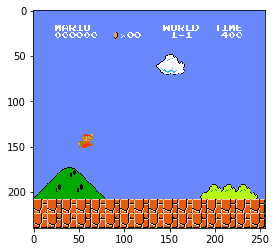

In [47]:
import matplotlib.pyplot as plt 
plt.imshow(h)
plt.show()

In [48]:
print(done)

False


In [49]:
print(reward)

1


In [28]:
import numpy as np 
a,b,c,d = env.step(env.action_space.sample())
model.predict(a.reshape(1,240,256,3))

array([[3.4987988e-05, 7.7925561e-06, 7.5290119e-03, 9.5475543e-01,
        1.6911041e-06, 6.2990716e-06, 1.7567293e-09, 8.4045865e-07,
        1.3829242e-08, 3.6480512e-02, 8.9927134e-06, 1.1744222e-03]],
      dtype=float32)